# Process JRC IDEES Excel spreadsheets into much more machine readable datasets. 

This has also now been implemented in the main Euro-Calliope workflow (sector coupling branch), see: https://github.com/calliope-project/euro-calliope/tree/fe4547ba7c13f855a3bdfaf0acee68e70eac8e10/scripts/jrc-idees

In [1]:
import glob
import sys

import numpy as np
import pandas as pd
from styleframe import StyleFrame

import seaborn as sns

sys.path.append('../../src/construct/')
import util
idx = pd.IndexSlice
dir_path = '/Users/brynmorp/Data/Europe/JRC IDEES/unzipped/'

data_path = "../../data"
build_path = "../../build"

../src/construct/util.py:24: DeprecationWarning:invalid escape sequence \-


In [2]:
energy_balances = pd.read_csv(f'{build_path}/annual_energy_balances.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)
cat_names = pd.read_csv(f'{data_path}/energy_balance_category_names.csv', header=0, index_col=0)

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [687]:

def get_tertiary_sector_data(dir_path):
    end_uses = {
        'Space heating': 'space_heating', 
        'Space cooling': 'end_use_electricity', 
        'Hot water': 'water_heating', 
        'Catering': 'cooking' 
    }
    carrier_names = {
        'Advanced electric heating': 'electricity',
        'Biomass and wastes': 'biofuel',
        'Conventional electric heating': 'electricity',
        'Conventional gas heaters': 'gas',
        'Derived heat': 'heat',
        'Electric space cooling': 'electricity',
        'Electricity': 'electricity',
        'Electricity in circulation and other use': 'electricity',
        'Gas heat pumps': 'gas',
        'Gas/Diesel oil incl. biofuels (GDO)': 'oil',
        'Gases incl. biogas': 'gas',
        'Geothermal energy': 'renewable_heat',
        'Liquified petroleum gas (LPG)': 'oil', 
        'Solar': 'renewable_heat',
        'Solids': 'solid_fossil'
    }
    files = glob.glob(f'{dir_path}/JRC-IDEES-2015_Tertiary_*')
    dfs = []
    
    for file in files:
        df_consumption = pd.read_excel(file, sheet_name='SER_hh_fec', index_col=0)
        df_demand = pd.read_excel(file, sheet_name='SER_hh_tes', index_col=0)
        df_summary = pd.read_excel(file, sheet_name='SER_summary', index_col=0)
        def clean_df(df, energy_type):
            country_code = df.index.names[0].split(' - ')[0]
            df = df.assign(end_use=np.nan)
            df.loc[df.index.isin(end_uses.keys()), 'end_use'] = list(end_uses.keys())
            df.end_use = df.end_use.fillna(df.end_use.ffill())

            df = (
                df
                .dropna()
                .set_index('end_use', append=True)
                .drop(end_uses.keys(), level=0)
                .groupby([carrier_names, end_uses], level=[0, 1]).sum()
                .assign(country_code=country_code, unit='ktoe', energy=energy_type)
                .set_index(['country_code', 'unit', 'energy'], append=True)
                .rename_axis(columns='year', index=['carrier_name', 'end_use', 'country_code', 'unit', 'energy'])
            )
            return df
        
        df_consumption = clean_df(df_consumption, 'consumption')
        df_demand = clean_df(df_demand, 'demand')
        
        df = pd.concat([df_consumption, df_demand])
        
        df_elec = (
            df_summary
            .loc['Energy consumption by end-uses (ktoe)':'Shares of energy consumption in end-uses (in %)']
            .loc['Specific electricity uses']
            .rename_axis(index='year')
        )
        df.loc[('electricity', 'end_use_electricity'), :].update(df.loc[('electricity', 'end_use_electricity'), :].add(df_elec, axis=1))
        assert np.allclose(df.xs('consumption', level='energy').sum(), df_summary.loc['Energy consumption by fuel - Eurostat structure (ktoe)'].astype(float))
        
        dfs.append(df)
    return pd.concat(dfs).stack()

In [688]:
tertiary_end_use_df = get_tertiary_sector_data('/Users/brynmorp/Data/Europe/JRC IDEES/unzipped/')

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/pandas/core/indexing.py:1762: PerformanceWarning:indexing past lexsort depth may impact performance.


In [691]:
tertiary_end_use_df.to_csv(f'{data_path}/commercial/jrc_idees_processed_energy.csv')

In [675]:
def get_industry_sector_data(dir_path):
    carrier_names = {
        'Biomass': 'biofuel',
        'Coke': 'solid_fossil',
        'Derived gases': 'manufactured_gas',
        'Diesel oil (incl. biofuels)': 'oil',
        'Electricity': 'electricity',
        'LPG': 'oil',
        'Natural gas (incl. biogas)': 'natural_gas',
        'Other liquids': 'oil',
        'Refinery gas': 'oil',
        'Residual fuel oil': 'oil',
        'Solar and geothermal': 'renewable_heat',
        'Solids': 'solid_fossil',
        'Steam distributed': 'heat',
        'electricity': 'electricity',
        'natural_gas': 'natural_gas',
        'oil': 'oil'
    }
    sheets = ['ISI_fec', 'NFM_fec', 'CHI_fec', 'NMM_fec', 'PPA_fec', 'FBT_fec', 'TRE_fec', 'MAE_fec', 'TEL_fec', 'WWP_fec', 'OIS_fec']
    files = glob.glob(f'{dir_path}/JRC*_Industry_*')
    dfs = []
    end_use_descriptors = pd.read_csv(f'{data_path}/industry/jrc_idees_industry_process_end_uses.csv', index_col=0, header=0)
    for file in files:
        for sheet in sheets:
            style_df = StyleFrame.read_excel(file, read_style=True, sheet_name=sheet)
            df = pd.read_excel(file, sheet_name=sheet)
            col = str(style_df.data_df.columns[0])
            idx_end = [int(i) for i in style_df.index if 'Market shares of energy use' in str(style_df.loc[i, col])][0]

            colors = {
                'section': ['FF0070C0', 'FFC00000'],
                'end_use': ['4f6228', '984807'],
                'carrier_name': ['808080', 'e46c0a', '000000']
            }

            for k, v in colors.items():
                idx = style_df[col].style.font_color.isin(v).loc[:idx_end]
                df.loc[idx[idx == True].index, k] = [str(i) if str(i) != 'nan' else np.nan for i in style_df.loc[idx[idx == True].index, col]]
            df.loc[:idx_end, 'indent'] = [int(i) for i in style_df[col].style.indent.loc[:idx_end]]

            df = df.dropna(subset=['section', 'end_use', 'carrier_name'], how='all')
            df['end_use'] = df.end_use.fillna(df.section).ffill()
            df['section'] = df.section.ffill()

            df = df[df.indent >= df.indent.shift(-1).fillna(df.indent)]

            df['end_use_2'] = end_use_descriptors.loc[df.end_use].end_use.values
            df['carrier_name_2'] = end_use_descriptors.loc[df.end_use].carrier_name.values

            df['carrier_name'] = df.carrier_name.where(df.carrier_name != 'nan').fillna(df.carrier_name_2)
            df['end_use_2'] = df.end_use_2.ffill()

            df_grouped = (
                df
                .set_index(['end_use_2', 'carrier_name'])
                .groupby(level=[0, 1]).sum()
                .drop('indent', axis=1)
                .unstack('end_use_2')
                .groupby(carrier_names).sum()
                .stack('end_use_2')
                .assign(cat_name=col.split(': ')[1].split(' / ')[0], country_code=col.split(': ')[0], unit='ktoe')
                .set_index(['cat_name', 'country_code', 'unit'], append=True)
                .stack()
                .rename_axis(index=['carrier_name', 'end_use', 'cat_name', 'country_code', 'unit', 'year'])
            )
            dfs.append(df_grouped)
    return pd.concat(dfs)

In [676]:
industry_end_use_df = get_industry_sector_data('/Users/brynmorp/Data/Europe/JRC IDEES/unzipped/')

In [687]:
industry_end_use_df.to_csv(f'{data_path}/industry/JRC_IDEES_industry_end_use_consumption.csv')

AttributeError: 'Index' object has no attribute 'apply'

In [289]:
DATASET_PARAMS = {
    "road-energy": {
        "sheet_name": "TrRoad_ene",
        "idx_start_str": "Total energy consumption",
        "idx_end_str": "Indicators",
        "unit": "ktoe"
    },
    "road-distance": {
        "sheet_name": "TrRoad_act",
        "idx_start_str": "Vehicle-km driven",
        "idx_end_str": "Stock of vehicles",
        "unit": "mio_km"
    },
    "road-vehicles": {
        "sheet_name": "TrRoad_act",
        "idx_start_str": "Stock of vehicles - in use",
        "idx_end_str": "New vehicle-registrations",
        "unit": "N. vehicles"
    },
    "rail-energy": {
        "sheet_name": "TrRail_ene",
        "idx_start_str": "Total energy consumption",
        "idx_end_str": "Indicators",
        "unit": "ktoe"
    },
    "rail-distance": {
        "sheet_name": "TrRail_act",
        "idx_start_str": "Vehicle-km (mio km)",
        "idx_end_str": "Stock of vehicles",
        "unit": "mio_km"
    },
}

ROAD_CARRIERS = {
    'Gasoline engine': 'petrol',
    'Diesel oil engine': 'diesel',
    'Natural gas engine': 'natural_gas',
    'LPG engine': 'lpg',
    'Battery electric vehicles': 'electricity',
    'Plug-in hybrid electric': 'petrol'
}

RAIL_CARRIERS = {
    'Diesel oil (incl. biofuels)': 'diesel',
    'Electric': 'electricity',
    'Diesel oil': 'diesel'
}
sheet_name = "TrRoad_act"
idx_start_str = "Vehicle-km driven"
idx_end_str = "Stock of vehicles"
unit = "mio_km"

file = glob.glob(f'{dir_path}/JRC*Transport*')[0]
style_df = StyleFrame.read_excel(file, read_style=True, sheet_name=sheet_name)
df = pd.read_excel(file, sheet_name=sheet_name)
column_names = str(style_df.data_df.columns[0])
idx_start = int(style_df[style_df[column_names].str.find(idx_start_str) > -1][0])
idx_end = int(style_df[style_df[column_names].str.find(idx_end_str) > -1][0])
df.assign(indent=style_df[column_names].style.indent.astype(int)).loc[idx_start:idx_end]

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


,SI - Road transport,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,indent
28,Vehicle-km driven (mio km),1.152103e+04,1.182018e+04,1.246834e+04,1.274364e+04,1.361562e+04,1.412563e+04,1.470089e+04,1.586797e+04,1.639923e+04,1.707255e+04,1.714805e+04,1.731325e+04,1.738520e+04,1.755552e+04,1.823619e+04,1.872959e+04,0
29,Passenger transport,1.077571e+04,1.101542e+04,1.156815e+04,1.177226e+04,1.238930e+04,1.280757e+04,1.328218e+04,1.430206e+04,1.477767e+04,1.551798e+04,1.562416e+04,1.573699e+04,1.578542e+04,1.585707e+04,1.636068e+04,1.670351e+04,1
30,Powered 2-wheelers,7.800000e+01,7.300000e+01,7.300000e+01,8.800000e+01,1.000000e+02,1.120000e+02,1.270000e+02,1.460000e+02,1.597121e+02,1.650000e+02,2.144985e+02,2.523742e+02,2.308681e+02,2.065242e+02,2.113762e+02,2.280654e+02,2
31,Passenger cars,1.058288e+04,1.083252e+04,1.138846e+04,1.158002e+04,1.218238e+04,1.259157e+04,1.304883e+04,1.404870e+04,1.450996e+04,1.524298e+04,1.529966e+04,1.537206e+04,1.544179e+04,1.553435e+04,1.602820e+04,1.634988e+04,2
32,Gasoline engine,8.532029e+03,8.598573e+03,8.311148e+03,8.441483e+03,8.349307e+03,8.132885e+03,7.947557e+03,7.990460e+03,7.808963e+03,7.726242e+03,7.373540e+03,7.114645e+03,6.823269e+03,6.559221e+03,6.444951e+03,6.343944e+03,3
33,Diesel oil engine,2.050856e+03,2.233942e+03,3.077312e+03,3.138541e+03,3.833075e+03,4.458685e+03,5.091654e+03,6.034852e+03,6.681388e+03,7.459039e+03,7.855805e+03,8.177435e+03,8.514384e+03,8.826018e+03,9.423395e+03,9.833044e+03,3
34,LPG engine,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.615789e+00,2.338785e+01,1.960654e+01,5.769729e+01,7.031794e+01,7.989475e+01,1.038452e+02,1.483167e+02,1.566997e+02,1.676790e+02,3
35,Natural gas engine,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.034641e-02,4.240266e-01,2.023727e+00,2.686354e+00,3
36,Plug-in hybrid electric,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.315367e-01,2.051155e-01,4.793724e-01,3
37,Battery electric vehicles,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.503364e-02,2.126795e-01,2.410996e-01,9.224740e-01,2.044202e+00,3


In [277]:
carrier_names = {
    'Biomass': 'biofuel',
    'Coke': 'solid_fossil',
    'Derived gases': 'manufactured_gas',
    'Diesel oil (incl. biofuels)': 'oil',
    'Diesel oil': 'oil',
    'Electricity': 'electricity',
    'LPG': 'oil',
    'Natural gas (incl. biogas)': 'natural_gas',
    'Natural gas': 'natural_gas',
    'Other liquids': 'oil',
    'Refinery gas': 'oil',
    'Residual fuel oil': 'oil',
    'Solar and geothermal': 'renewable_heat',
    'Solids': 'solid_fossil',
    'Steam distributed': 'heat',
    'electricity': 'electricity',
    'natural_gas': 'natural_gas',
    'oil': 'oil'
}


def get_jrc_idees_energy_sheet(sheet_name, dir_path):
    files = glob.glob(f'{dir_path}/JRC*_Industry_*')
    dfs = []
    for file in files:
        style_df = StyleFrame.read_excel(file, read_style=True, sheet_name=sheet_name)
        df = pd.read_excel(file, sheet_name=sheet_name)
        col = str(style_df.data_df.columns[0])
        idx_end = [int(i) for i in style_df.index if 'Market shares' in str(style_df.loc[i, col])][0]
        colors = {
            'section': ['FFC00000'],
            'subsection': ['FF0070C0', '4f6228', '953735'],
            'end_use': ['984807'],
            'carrier_name': ['808080', 'e46c0a', '000000', 'dc9e9c']
        }

        for k, v in colors.items():
            idx = style_df[col].style.font_color.isin(v).loc[:idx_end]
            df.loc[idx[idx == True].index, k] = [str(i) if str(i) != 'nan' else np.nan for i in style_df.loc[idx[idx == True].index, col]]
        df.loc[:idx_end, 'indent'] = [int(i) for i in style_df[col].style.indent.loc[:idx_end]]

        # To check at the end that we haven't lost some data
        tot = df[df.indent == 1].sum()
        
        df = df.dropna(subset=['section', 'subsection', 'end_use', 'carrier_name'], how='all')
        #df['end_use'] = df.end_use.fillna(df.section).ffill()
        df['section'] = df.section.ffill()
        df['subsection'] = df.subsection.ffill()
        df.loc[
            df.end_use.str.lower().str.contains('electric|microwave|freeze|mechanical', regex=True, na=False),
            'carrier_name'
        ] = 'Electricity'
        df.loc[
            df.subsection.str.lower().str.contains('diesel', regex=True, na=False),
            'carrier_name'
        ] = 'Diesel oil (incl. biofuels)'
        df.loc[
            df.end_use.str.lower().str.contains('gas|thermal cooling|thermal connection', regex=True, na=False),
            'carrier_name'
        ] = 'Natural gas (incl. biogas)'
        df.loc[
            df.end_use.str.lower().str.contains('gas', regex=True, na=False),
            'carrier_name'
        ] = 'Natural gas (incl. biogas)'
        df.loc[df.end_use.isnull(), 'carrier_name'] = df.loc[df.end_use.isnull(), 'carrier_name'].fillna('Electricity')
        #
        df = df[df.indent >= df.indent.shift(-1).fillna(df.indent)]
        #
        #
        df = (
            df
            .assign(cat_name=col.split(': ')[1].split(' / ')[0], country_code=col.split(': ')[0], unit='ktoe')
            .set_index(['section', 'subsection', 'carrier_name', 'country_code', 'cat_name', 'unit'])
            .drop([col, 'indent', 'end_use'], axis=1)
            .groupby(level=[0, 1, 2, 3, 4, 5]).sum()
        )
        # Check that we haven't lost some data
        assert np.allclose(tot.reindex(df.columns).astype(float), df.sum().astype(float))
        
        dfs.append(df)
        
    return pd.concat(dfs)
    
def get_jrc_idees_production(sheet_name, dir_path):
    files = glob.glob(f'{dir_path}/JRC*_Industry_*')
    dfs = []
    for file in files:
        df = pd.read_excel(file, sheet_name=sheet_name, index_col=0)
        start = df.filter(regex='Physical output', axis=0)
        end = df.filter(regex='Installed capacity', axis=0)
        
        df_prod = (
            df
            .loc[start.index[0]:end.index[0]]
            .iloc[1:-1]
            .dropna(how='all')
            .assign(country_code=df.index.name.split(':')[0], cat_name=df.index.name.split(': ')[1], unit='kt')
            .rename_axis(index='produced_material')
            .set_index(['country_code', 'cat_name', 'unit'], append=True)
        )
        
        dfs.append(df_prod)
        
    return pd.concat(dfs)

def get_all_jrc_idees(dir_path):
    sheets = ['ISI', 'NFM', 'CHI', 'NMM', 'PPA', 'FBT', 'TRE', 'MAE', 'TEL', 'WWP', 'OIS']
    fec_df = pd.concat(get_jrc_idees_energy_sheet(f'{sheet}_fec', dir_path) for sheet in sheets)
    ued_df = pd.concat(get_jrc_idees_energy_sheet(f'{sheet}_ued', dir_path) for sheet in sheets)
    prod_df = pd.concat(get_jrc_idees_production(sheet, dir_path) for sheet in sheets)
    df = pd.concat(
        [fec_df, ued_df.reorder_levels(fec_df.index.names), prod_df.reorder_levels(fec_df.index.names)], 
        names='datatype', keys=['consumption', 'demand', 'production']
    )
    return df

In [282]:
sheets = ['ISI', 'NFM', 'CHI', 'NMM', 'PPA', 'FBT', 'TRE', 'MAE', 'TEL', 'WWP', 'OIS']
fec_df = pd.concat(get_jrc_idees_energy_sheet(f'{sheet}_fec', dir_path) for sheet in sheets)
ued_df = pd.concat(get_jrc_idees_energy_sheet(f'{sheet}_ued', dir_path) for sheet in sheets)
prod_df = pd.concat(get_jrc_idees_production(sheet, dir_path) for sheet in sheets)
energy_df = pd.concat(
    [fec_df, ued_df], 
    names=['energy'], keys=['consumption', 'demand']
)

In [288]:
energy_df.to_csv(f'{data_path}/industry/jrc_idees_processed_energy.csv.gz')
prod_df.to_csv(f'{data_path}/industry/jrc_idees_processed_production.csv.gz')

In [896]:
carrier_names = {
    'Biomass': 'biofuel',
    'Coke': 'solid_fossil',
    'Derived gases': 'gas',
    'Diesel oil (incl. biofuels)': 'oil',
    'Diesel oil': 'oil',
    'Electricity': 'electricity',
    'LPG': 'oil',
    'Natural gas (incl. biogas)': 'gas',
    'Natural gas': 'gas',
    'Other liquids': 'oil',
    'Refinery gas': 'oil',
    'Residual fuel oil': 'oil',
    'Solar and geothermal': 'renewable_heat',
    'Solids': 'solid_fossil',
    'Steam distributed': 'heat',
    'electricity': 'electricity',
    'natural_gas': 'natural_gas',
    'oil': 'oil'
}
energy_grouped_df = (
    energy_df
    .stack()
    .unstack('carrier_name')
    .groupby(carrier_names, axis=1)
    .sum(min_count=1)
    .rename_axis(columns='carrier_name')
    .unstack(-1).stack(0)
)

In [906]:
def get_carrier_demand(carrier, energy_df):
    energy = energy_df.xs(carrier, level='carrier_name')
    energy_efficiency = energy.xs('demand').div(energy.xs('consumption'))
    demand = energy_df.xs('demand').sum(level=['section', 'subsection', 'country_code', 'cat_name', 'unit'])
    # Fill NaNs (where there is demand, but no electrical consumption in that country)
    # with the average efficiency a. from the country, b. from all countries
    energy_efficiency = (
        energy_efficiency
        .T # have to reorient the array thanks to a NotImplementedError
        .fillna(energy_efficiency.mean(axis=1))
        .T # have to reorient the array thanks to a NotImplementedError
        .fillna(energy_efficiency.mean())
    )    
    return demand.reindex(energy_efficiency.index).div(energy_efficiency)



electrical_consumption = get_carrier_demand('electricity', energy_grouped_df)
nat_gas_consumption = get_carrier_demand('gas', energy_grouped_df)
diesel_consumption = get_carrier_demand('oil', energy_grouped_df)


In [912]:
electrical_end_use = electrical_consumption.drop(nat_gas_consumption.index, errors='ignore')
process_heat_low = electrical_consumption.drop(electrical_end_use.index)
process_heat_high = nat_gas_consumption.drop(electrical_consumption.index, errors='ignore')


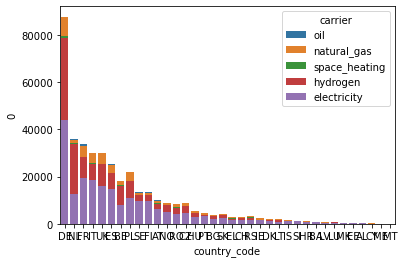

In [1402]:
processed_annual_industry_demand = pd.read_csv(f'{build_path}/annual_industry_energy_demand.csv', index_col=[0, 1, 2, 3])
foo = processed_annual_industry_demand.sum(level=['country_code', 'carrier']).drop('co2', level='carrier')
country_order = foo.sum(level=['country_code'])['2015.0'].sort_values(ascending=False).index
_df = foo['2018.0'].unstack('carrier').cumsum(axis=1).stack().reset_index()
sns.barplot(
    data=_df,
    y=0, 
    x='country_code', 
    hue='carrier',
    hue_order=_df.carrier.unique()[::-1],
    order=country_order,
    dodge=False
)

# Transport

In [6]:
files = glob.glob(f'{dir_path}/JRC*_Transport_*')

def read_transport_excel(files, sheet_name, idx_start_str, idx_end_str, unit):
    dfs = []
    for file in files:
        style_df = StyleFrame.read_excel(file, read_style=True, sheet_name=sheet_name)
        df = pd.read_excel(file, sheet_name=sheet_name)
        col = str(style_df.data_df.columns[0])
        idx_start = [int(i) for i in style_df.index if idx_start_str in str(style_df.loc[i, col])][0]
        idx_end = [int(i) for i in style_df.index if idx_end_str in str(style_df.loc[i, col])][0]
        df.loc[idx_start:idx_end, 'indent'] = [int(i) for i in style_df[col].style.indent.loc[idx_start:idx_end]]

        df = df.dropna(subset=['indent'])
        tot = df.iloc[0]
        df['section'] = df.where(df.indent == 1).iloc[:, 0].ffill()
        df['vehicle_type'] = df.where(df.indent == 2).iloc[:, 0].ffill()

        
        if sheet_name == 'TrRoad_act':
            df['vehicle_subtype'] = df.where(df.indent == 3).iloc[:, 0]
            df = df.where(
                (df.indent == 3) | (df.vehicle_type == 'Powered 2-wheelers')
            ).dropna(how='all')
            df.loc[df.vehicle_type == 'Powered 2-wheelers', 'vehicle_subtype'] = 'Gasoline engine'
            df = (
                df
                .set_index(['section', 'vehicle_type', 'vehicle_subtype'])
                .drop([col, 'indent'], axis=1)
            )
        elif sheet_name == 'TrRoad_ene':
            df['vehicle_subtype'] = df.where(df.indent == 3).iloc[:, 0].ffill()
            # Deal with the annoying nature of the spreadsheets
            df['vehicle_type'] = df['vehicle_type'].str.split('(', expand=True)[0].str.strip()
            df['vehicle_subtype'] = df['vehicle_subtype'].str.split('(', expand=True)[0].str.strip()
            df.loc[df.vehicle_type == 'Powered 2-wheelers', 'vehicle_subtype'] = 'Gasoline engine'
            df['carrier'] = df.where(df.indent == 4).iloc[:, 0]
            df['carrier'] = df['carrier'].str.replace('of which ', '')
            df.loc[(df.vehicle_type == 'Powered 2-wheelers') & (df.indent == 2), 'carrier'] = 'petrol'
            df.loc[(df.vehicle_type == 'Powered 2-wheelers') & (df.indent == 3), 'carrier'] = 'biofuels'
            df.loc[(df.vehicle_subtype == 'Domestic') & (df.indent == 3), 'carrier'] = 'diesel'
            df.loc[(df.vehicle_subtype == 'International') & (df.indent == 3), 'carrier'] = 'diesel'
            df['carrier'] = df['carrier'].fillna(df.vehicle_subtype.replace({
                'Gasoline engine': 'petrol', 'Diesel oil engine': 'diesel',
                'Natural gas engine': 'natural_gas', 'LPG engine': 'lpg',
                'Battery electric vehicles': 'electricity', 'Plug-in hybrid electric': 'petrol'
            }))
            df = (
                df
                .where((df.indent > 2) | (df.vehicle_type == 'Powered 2-wheelers'))
                .dropna()
                .set_index(['section', 'vehicle_type', 'vehicle_subtype', 'carrier'])
                .drop([col, 'indent'], axis=1)
            )
            # subfuels (e.g. biodiesel) are given as 'of which ...', meaning the main fuel consumption
            # includes those fuels (diesel is actually diesel + biofuels). We rectify that here
            def remove_of_which(df, main_carrier, of_which_carrier):
                updated_carrier = (
                    (df.xs(main_carrier, level='carrier') - df.xs(of_which_carrier, level='carrier'))
                    .dropna()
                    .assign(carrier=main_carrier)
                    .set_index('carrier', append=True)
                )
                df.loc[updated_carrier.index] = updated_carrier
                return df

            df = remove_of_which(df, 'diesel', 'biofuels')
            df = remove_of_which(df, 'petrol', 'biofuels')
            df = remove_of_which(df, 'petrol', 'electricity')
            df = remove_of_which(df, 'natural_gas', 'biogas')
            
        elif sheet_name == 'TrRail_ene' or sheet_name == 'TrRail_act':
            df['carrier'] = df.where(df.indent == 3).iloc[:, 0]
            df.loc[df.vehicle_type == 'Metro and tram, urban light rail', 'carrier'] = 'electricity'
            df.loc[df.vehicle_type == 'High speed passenger trains', 'carrier'] = 'electricity'
            carriers = {
                'Diesel oil (incl. biofuels)': 'diesel', 
                'Electric': 'electricity',
                'Diesel oil': 'diesel'
            }
            df['carrier'] = df['carrier'].replace(carriers).fillna(df.vehicle_type.replace(carriers))
            df.loc[df.section == 'Freight transport', 'vehicle_type'] = 'Freight'
            
            df = (
                df
                .where((df.indent > 1) & (df.carrier.str.find('Conventional') == -1))
                .dropna()
                .set_index(['section', 'vehicle_type', 'carrier'])
                .drop([col, 'indent'], axis=1)
            )
            
        df = (
            df
            .assign(country_code=col.split(' - ')[0], unit=unit)
            .set_index(['country_code', 'unit'], append=True)
        )
        df.columns = df.columns.astype(int).rename('year')
        
        # After all this hardcoded cleanup, make sure numbers match up
        assert np.allclose(df.sum(), tot.loc[df.columns].astype(float))
    
        dfs.append(df)
    return pd.concat(dfs)

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


In [ ]:
transport_distance = read_transport_excel(
    files, 'TrRoad_act', 'Vehicle-km driven', 'Stock of vehicles', 'mio_km'
)

In [ ]:
transport_energy = read_transport_excel(
    files, 'TrRoad_ene', 'Total energy consumption', 'Indicators', 'ktoe'
)
transport_energy = transport_energy.apply(util.ktoe_to_twh)
transport_energy.index = transport_energy.index.set_levels(['twh'], level='unit')

transport_distance = read_transport_excel(
    files, 'TrRoad_act', 'Vehicle-km driven', 'Stock of vehicles', 'mio_km'
)
transport_vehicles = read_transport_excel(
    files, 'TrRoad_act', 'Stock of vehicles - in use', 'New vehicle-registrations', 'N. vehicles'
)

rail_energy = read_transport_excel(
    files, 'TrRail_ene', 'Total energy consumption', 'Indicators', 'ktoe'
)
rail_energy = rail_energy.apply(util.ktoe_to_twh)
rail_energy.index = rail_energy.index.set_levels(['twh'], level='unit')

rail_distance = read_transport_excel(
    files, 'TrRail_act', 'Vehicle-km (mio km)', 'Stock of vehicles', 'mio_km'
)

In [1694]:
transport_energy.stack('year').to_csv(f'{data_path}/transport/jrc_idees_processed_road_energy.csv')
transport_distance.stack('year').to_csv(f'{data_path}/transport/jrc_idees_processed_road_distance.csv')
transport_vehicles.stack('year').to_csv(f'{data_path}/transport/jrc_idees_processed_road_vehicles.csv')
rail_energy.stack('year').to_csv(f'{data_path}/transport/jrc_idees_processed_rail_energy.csv')
rail_distance.stack('year').to_csv(f'{data_path}/transport/jrc_idees_processed_rail_distance.csv')

In [ ]:
import annual_transport_demand

energy_balances = util.read_tdf(f'{build_path}/annual_energy_balances.csv')
road_energy_df = util.read_tdf(f'{data_path}/transport/jrc_idees_processed_road_energy.csv')
road_distance_df = util.read_tdf(f'{data_path}/transport/jrc_idees_processed_road_distance.csv')
    
total_road_distance, road_efficiency, road_bau_consumption = annual_transport_demand.get_all_distance_efficiency(
    energy_balances, 'FC_TRA_ROAD_E', road_energy_df, road_distance_df, 'vehicle_subtype'
)

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.


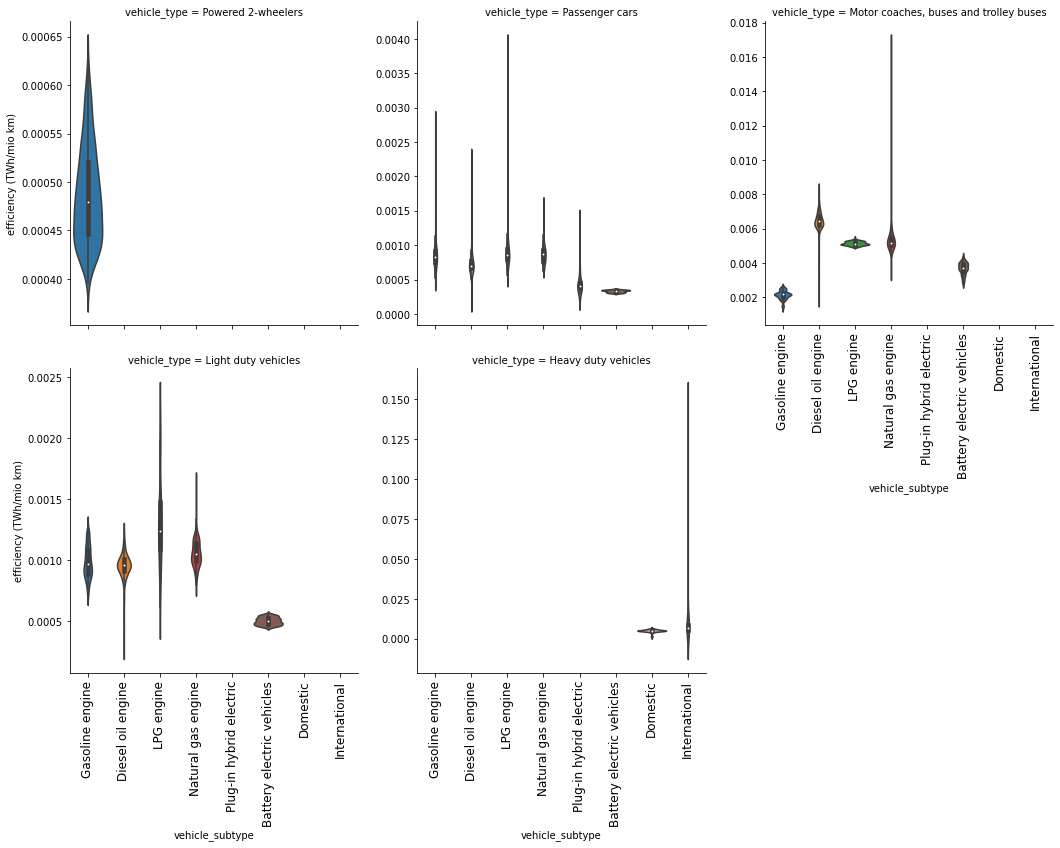

In [1346]:
g = sns.catplot(
    data=(1 / road_efficiency.stack()).to_frame('efficiency (TWh/mio km)').reset_index(),
    x='vehicle_subtype', y='efficiency (TWh/mio km)', col='vehicle_type', col_wrap=3, 
    sharey=False, kind='violin'
)
foo = [ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center', size=12) for ax in g.axes.flat]